In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import LeaveOneGroupOut
import dotenv
import pathlib
from mlgut.pystab import nogueria_test
from mlgut import utils
from mlgut.datasets import get_path
from mlgut.models import (
    compute_rbo_mat,
    compute_support_ebm,
    get_cp_support,
    get_lopo_support,
)

EXTENSIONS = ["pdf", "png", "svg"]

PROJECT_NAMES_DICT = {
    "PRJNA389927": "Hannigan",
    "PRJEB12449": "Vogtmann",
    "PRJEB6070": "Zeller",
    "PRJEB7774": "Feng",
    "PRJEB10878": "Yu",
    "PRJNA447983": "Thomas0",
    "PRJEB27928": "Thomas1",
}

PROJECT_ORDER = sorted(PROJECT_NAMES_DICT.values())
DISEASE_COLUMN_NAME = "DISEASE"
PROJECT_COLUMN_NAME = "SECONDARY_STUDY_ID"


def load_crossproject(condition, profile, path):
    crossproject_fname = f"{condition}_{profile}_cross_project.jbl"
    crossproject_fpath = path.joinpath(crossproject_fname)
    crossproject_results = joblib.load(crossproject_fpath)
    crossproject_results = utils.rename_keys(crossproject_results, PROJECT_NAMES_DICT)

    return crossproject_results


def load_stability(condition, profile, path):
    stability_fname = f"{condition}_{profile}_stability.jbl"
    stability_fpath = path.joinpath(stability_fname)
    stability_results = joblib.load(stability_fpath)
    stability_results = utils.rename_keys(stability_results, PROJECT_NAMES_DICT)

    return stability_results


def compute_error(results, alpha=0.05, metric="roc_auc"):
    # Z matrix in Nogueira's stability paper
    metric_str = f"test_{metric}"
    scores = np.array(results[metric_str])
    n_splits = scores.size

    mean_score = np.mean(scores)
    ci = stats.norm.ppf(1 - alpha / 2) * (np.std(scores)) / np.sqrt(n_splits)

    return scores, mean_score, ci


def compute_stability(results, alpha=0.05):
    # Z matrix in Nogueira's stability paper

    support_matrix = [
        model["selector"].get_support() * 1 for model in results["estimator"]
    ]
    support_matrix = np.array(support_matrix)

    stab_res = nogueria_test(support_matrix, alpha=alpha)
    stability = stab_res.estimator
    stability_error = stab_res.error

    return support_matrix, stability, stability_error


def analyze_stability(
    stability_results, crossproject_results, condition, profile, path
):
    stability_results_df = {
        key: compute_stability(stability_results[key])[1:]
        for key in stability_results.keys()
    }
    stability_results_df = pd.DataFrame(
        stability_results_df, index=["estability", "error"]
    )
    stability_results_df = stability_results_df.T.sort_index()

    crossproject_results_df = {
        key: compute_stability(crossproject_results[key]["cv"])[1:]
        for key in crossproject_results.keys()
    }
    crossproject_results_df = pd.DataFrame(
        crossproject_results_df, index=["estability", "error"]
    )
    crossproject_results_df = crossproject_results_df.T.sort_index()

    roc_auc_stability = {
        key: compute_error(stability_results[key])[0]
        for key in stability_results.keys()
    }

    roc_auc_stability = pd.DataFrame(roc_auc_stability).melt(
        value_name="Mean AUROC", var_name="Project"
    )

    roc_auc_crossproject = {
        key: compute_error(crossproject_results[key]["cv"])[0]
        for key in crossproject_results.keys()
    }
    roc_auc_crossproject = pd.DataFrame(roc_auc_crossproject).melt(
        value_name="Mean AUROC", var_name="Project"
    )

    plot_stability(
        crossproject_results_df, stability_results_df, condition, profile, path
    )
    plot_error(roc_auc_crossproject, roc_auc_stability, condition, profile, path)

    return roc_auc_crossproject


def plot_stability(cp_df, stab_df, condition, profile, path):
    plt.style.use("fivethirtyeight")
    _, ax = plt.subplots(1, 1, figsize=(16, 9))
    plt.errorbar(
        x=cp_df.index,
        y=cp_df["estability"],
        yerr=cp_df["error"],
        label=["CV-stability"],
    )
    plt.errorbar(
        x=stab_df.index,
        y=stab_df["estability"],
        yerr=stab_df["error"],
        label=["RSSS-stability"],
    )
    ax.set_xlabel("Project")
    ax.set_ylabel("Stability")
    plt.legend(loc="lower right")
    plt.tight_layout()
    for ext in EXTENSIONS:
        fname = f"{condition}_{profile}_feature_selection_stability.{ext}"
        fpath = path.joinpath(fname)
        plt.savefig(fpath, dpi=300, bbox_inches="tight", pad_inches=0)
    plt.close()


def plot_error(cp_df, stab_df, condition, profile, path):
    _, ax = plt.subplots(1, 1, figsize=(16, 9))

    sns.lineplot(
        x="Project",
        y="Mean AUROC",
        data=cp_df,
        ax=ax,
        err_style="bars",
        ci=95,
        label="CV-test",
    )
    sns.lineplot(
        x="Project",
        y="Mean AUROC",
        data=stab_df,
        ax=ax,
        err_style="bars",
        ci=95,
        label="RSSS-test",
    )
    plt.legend(loc="lower right")
    plt.tight_layout()
    for ext in EXTENSIONS:
        fname = f"{condition}_{profile}_feature_selection_stability_error.{ext}"
        fpath = path.joinpath(fname)
        plt.savefig(fpath, dpi=300, bbox_inches="tight", pad_inches=0)
    plt.close()


def analyze_rank_stability(results, features, profile, condition, path):
    def compute_ebm_fi_by_project(results, key):
        ebm_fi_list = [
            pd.Series(compute_support_ebm(model)[1], index=features.columns)
            for model in results[key]["cv"]["estimator"]
        ]
        ebm_fi = pd.concat(ebm_fi_list, axis=1)

        return ebm_fi

    ebm_fi_by_project = {
        key: compute_ebm_fi_by_project(results, key) for key in results.keys()
    }

    dmat = {
        key: compute_rbo_mat(ebm_fi_by_project[key]) for key in ebm_fi_by_project.keys()
    }

    dmat = pd.DataFrame(dmat).melt(value_name="dRBO", var_name="Project")
    fname = f"{condition}_{profile}_rank_stability_mat.jbl"
    fpath = path.joinpath(fname)
    joblib.dump(dmat, fpath)

    plt.figure(figsize=(16, 9))
    sns.violinplot(x="Project", y="dRBO", data=dmat, order=PROJECT_ORDER)
    plt.ylim([-0.1, 1.1])
    plt.tight_layout()
    for ext in EXTENSIONS:
        fname = f"{condition}_{profile}_rank_stability.{ext}"
        fpath = path.joinpath(fname)
        plt.savefig(fpath, dpi=300, bbox_inches="tight", pad_inches=0)
    plt.close()


def analyze_lopo_wo_oracle(results, features, metadata, profile, condition, control):
    query = metadata[DISEASE_COLUMN_NAME].isin([control, condition])
    projects = metadata.loc[query, PROJECT_COLUMN_NAME]

    lopo_mean = dict(zip(np.unique(projects), results["test_roc_auc"]))
    lopo_mean = utils.rename_keys(lopo_mean, PROJECT_NAMES_DICT)

    _, support_merged = get_lopo_support(results, features.columns)

    print(lopo_mean, np.mean(results["test_roc_auc"]))

    return lopo_mean, support_merged


def analyze_lopo_with_oracle(results, metadata, profile, condition, control):
    query = metadata[DISEASE_COLUMN_NAME].isin([control, condition])
    projects = metadata.loc[query, PROJECT_COLUMN_NAME]

    best = 0.0
    keep = {}
    best_support = []
    for i in results.keys():
        # top: at least in `i` LOPO trainings.
        lopo_mean_i = dict(zip(np.unique(projects), results[i]["cv"]["test_roc_auc"]))
        mean_i = np.mean(results[i]["cv"]["test_roc_auc"])
        lopo_mean_i = utils.rename_keys(lopo_mean_i, PROJECT_NAMES_DICT)
        if mean_i > best:
            best = mean_i
            keep = lopo_mean_i
            columns = results[i]["columns"]
            _, best_support = get_lopo_support(results[i]["cv"], columns)

        print(lopo_mean_i, mean_i)

    return keep, best_support


def plot_lopo(frame, support, profile, condition, path, oracle=True):
    if oracle:
        with_str = "with"
    else:
        with_str = "wo"
    print(frame)
    fname = f"{condition}_{profile}_lopo_{with_str} _oracle_support.tsv"
    fpath = path.joinpath(fname)
    support.to_csv(fpath, sep="\t")


def get_cross_project_data(names, profile, condition, results):

    l = []
    for project_id in results.keys():
        r = results[project_id]["outer"][
            [PROJECT_COLUMN_NAME, DISEASE_COLUMN_NAME, "decission"]
        ].copy()
        r[PROJECT_COLUMN_NAME] = r[PROJECT_COLUMN_NAME].replace(PROJECT_NAMES_DICT)
        r = r.groupby(PROJECT_COLUMN_NAME).apply(
            lambda x: metrics.roc_auc_score(
                x[DISEASE_COLUMN_NAME] == condition, x["decission"]
            )
        )
        r.name = project_id
        l.append(r)

    r = pd.concat(l, axis=1).T
    for project_id in results.keys():
        r.loc[project_id, project_id] = np.mean(
            results[project_id]["cv"]["test_roc_auc"]
        )

    fi, fi_merged = get_cp_support(results, names)

    return r, fi, fi_merged


def build_scoring_mat(cp_mat, lopo_wo_oracle, lopo_with_oracle):

    mat = cp_mat.copy()
    mat = mat.loc[PROJECT_ORDER, PROJECT_ORDER]
    mat.loc["Mean", :] = mat.mean(axis=0)
    lopo_wo_oracle_series = pd.Series(lopo_wo_oracle, name="LOPO")
    lopo_with_oracle_series = pd.Series(lopo_with_oracle, name="oLOPO")
    mat = mat.append(lopo_wo_oracle_series)
    mat = mat.append(lopo_with_oracle_series)
    mat["Mean"] = mat.mean(axis=1)

    return mat


def plot_scores(mat, condition, profile, path):

    plt.figure()
    ax = sns.heatmap(
        mat,
        annot=True,
        fmt=".2f",
        vmin=0.0,
        vmax=1.0,
        cbar=False,
        xticklabels=True,
        yticklabels=True,
    )
    ax.xaxis.set_ticks_position("top")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    for ext in EXTENSIONS:
        fname = f"{condition}_{profile}_score_matrix.{ext}"
        fpath = path.joinpath(fname)
        plt.savefig(fpath, dpi=300, bbox_inches="tight", pad_inches=0)
    plt.close()


def load_lopo(condition, profile, path, oracle=False):
    if oracle:
        with_str = "with"
    else:
        with_str = "wo"

    fname = f"{condition}_{profile}_lopo_{with_str}_oracle.jbl"
    fpath = path.joinpath(fname)
    results = joblib.load(fpath)

    return results


def build_analysis(features, metadata, profile, condition, control, path):
    results_stab = load_stability(condition, profile, path)
    results_cp = load_crossproject(condition, profile, path)
    results_lopo_wo_oracle = load_lopo(condition, profile, path, oracle=False)
    results_lopo_with_oracle = load_lopo(condition, profile, path, oracle=True)

    metadata_ = metadata.copy()
    metadata_[PROJECT_COLUMN_NAME] = metadata_[PROJECT_COLUMN_NAME].replace(
        PROJECT_NAMES_DICT
    )

    cp_mat, cp_fi, cp_fi_merged = get_cross_project_data(
        features.columns, profile, condition, results_cp
    )
    cp_fi.to_csv(path.joinpath(f"{condition}_{profile}_cp_support.tsv"), sep="\t")
    cp_fi_merged.to_csv(
        path.joinpath(f"{condition}_{profile}_cp_support_merge.tsv"), sep="\t"
    )

    lopo_wo_oracle, support_lopo_wo_oracle = analyze_lopo_wo_oracle(
        results_lopo_wo_oracle, features, metadata, profile, condition, control
    )
    lopo_with_oracle, support_lopo_with_oracle = analyze_lopo_with_oracle(
        results_lopo_with_oracle, metadata, profile, condition, control
    )

    score_mat = build_scoring_mat(cp_mat, lopo_wo_oracle, lopo_with_oracle)
    plot_scores(score_mat, condition, profile, path)

    plot_lopo(
        lopo_wo_oracle, support_lopo_wo_oracle, profile, condition, path, oracle=False
    )
    plot_lopo(
        lopo_with_oracle,
        support_lopo_with_oracle,
        profile,
        condition,
        path,
        oracle=True,
    )

    analyze_stability(results_stab, results_cp, condition, profile, path)
    analyze_rank_stability(results_cp, features, profile, condition, path)


In [3]:
project_path = pathlib.Path(dotenv.find_dotenv()).parent
results_path = project_path.joinpath("data", "paper")


In [4]:
condition = "CRC"
profile = "centrifuge"
ext="jbl"

In [5]:
%load_ext autoreload
%autoreload 2


In [9]:
stab_df = pd.DataFrame()
results_stab_dict = {}
results_cp_dict = {}

profile_names = ["centrifuge", "KEGG_KOs", "OGs"]

for profile in profile_names:
    print(profile)
    path = results_path.joinpath(f"{condition.lower()}_{profile.lower()}_results")
    
    results_stab = load_stability(condition, profile, path)
    results_stab_dict[profile] = results_stab
    
    results_cp = load_crossproject(condition, profile, path)
    results_cp_dict[profile] = results_cp
    print(f"end {profile}")

centrifuge
end centrifuge
KEGG_KOs
end KEGG_KOs
OGs
end OGs


In [117]:
profile_names = ["centrifuge", "KEGG_KOs", "OGs"]
results_lopo_wo_oracle_dict = {}
results_lopo_with_oracle_dict = {}

for profile in profile_names:
    print(profile)
    path = results_path.joinpath(f"{condition.lower()}_{profile.lower()}_results")
    
    results_lopo_wo_oracle = load_lopo(condition, profile, path, oracle=False)
    results_lopo_wo_oracle_dict[profile] = results_lopo_wo_oracle
    
    results_lopo_with_oracle = load_lopo(condition, profile, path, oracle=True)
    results_lopo_with_oracle_dict[profile] = results_lopo_with_oracle
    print(f"end {profile}")    

centrifuge
end centrifuge
KEGG_KOs
end KEGG_KOs
OGs
end OGs


In [155]:
features_dict = {}
metadata_dict = {}
condition = "CRC"

from mlgut import datasets

for profile in profile_names:
    print(f"start {profile}") 
    features, metadata = datasets.build_condition_dataset(
        condition, profile, ext="jbl"
    )
    if "ogs" in profile.lower():
        features = datasets.filter_egg(features)
    if "cent" in profile.lower():
        tax_id = "9606"
        features = features.drop(tax_id, axis=1)
    features_dict[profile] = features
    metadata_dict[profile] = metadata
    print(f"end {profile}")   

start centrifuge
end centrifuge
start KEGG_KOs
end KEGG_KOs
start OGs
end OGs


In [125]:
def get_cm_mat(condition, results):

    l = []
    for project_id in results.keys():
        r = results[project_id]["outer"][
            [PROJECT_COLUMN_NAME, DISEASE_COLUMN_NAME, "decission"]
        ].copy()
        r[PROJECT_COLUMN_NAME] = r[PROJECT_COLUMN_NAME].replace(PROJECT_NAMES_DICT)
        r = r.groupby(PROJECT_COLUMN_NAME).apply(
            lambda x: metrics.roc_auc_score(
                x[DISEASE_COLUMN_NAME] == condition, x["decission"]
            )
        )
        r.name = project_id
        l.append(r)

    r = pd.concat(l, axis=1).T
    
    for project_id in results.keys():
        r.loc[project_id, project_id] = np.mean(
            results[project_id]["cv"]["test_roc_auc"]
        )
    
    return r

In [ ]:
def get_lopo_score_with_oracle(results, features, metadata, profile, condition, control):
    query = metadata[DISEASE_COLUMN_NAME].isin([control, condition])
    projects = metadata.loc[query, PROJECT_COLUMN_NAME]

    lopo_mean = dict(zip(np.unique(projects), results["test_roc_auc"]))
    lopo_mean = utils.rename_keys(lopo_mean, PROJECT_NAMES_DICT)

    _, support_merged = get_lopo_support(results, features.columns)

    print(lopo_mean, np.mean(results["test_roc_auc"]))

    return lopo_mean, support_merged


def analyze_lopo_with_oracle(results, metadata, profile, condition, control):
    query = metadata[DISEASE_COLUMN_NAME].isin([control, condition])
    projects = metadata.loc[query, PROJECT_COLUMN_NAME]

    best = 0.0
    keep = {}
    best_support = []
    for i in results.keys():
        # top: at least in `i` LOPO trainings.
        lopo_mean_i = dict(zip(np.unique(projects), results[i]["cv"]["test_roc_auc"]))
        mean_i = np.mean(results[i]["cv"]["test_roc_auc"])
        lopo_mean_i = utils.rename_keys(lopo_mean_i, PROJECT_NAMES_DICT)
        if mean_i > best:
            best = mean_i
            keep = lopo_mean_i
            columns = results[i]["columns"]
            _, best_support = get_lopo_support(results[i]["cv"], columns)

        print(lopo_mean_i, mean_i)

    return keep, best_support

In [126]:
cm_mat = get_cm_mat("CRC", results_cp_dict[profile_names[0]])
cm_mat

,Feng,Hannigan,Thomas0,Thomas1,Yu,Zeller,Vogtmann
Vogtmann,0.847692,0.641534,0.748480,0.718939,0.735986,0.698680,0.738400
Thomas1,0.946154,0.698413,0.705927,0.909167,0.878879,0.700147,0.755279
Zeller,0.829231,0.669312,0.803951,0.778030,0.762513,0.926786,0.708522
Feng,0.948000,0.652116,0.757599,0.843939,0.756256,0.672104,0.674962
Yu,0.883077,0.578042,0.714286,0.859848,0.855250,0.759531,0.740196
Hannigan,0.692308,0.492222,0.548632,0.696591,0.743869,0.745601,0.571078
Thomas0,0.880000,0.642857,0.772250,0.718182,0.752002,0.809934,0.662519


In [129]:
score_mat = build_scoring_mat(cm_mat, results_lopo_wo_oracle_dict[profile_names[0]], results_lopo_with_oracle_dict[profile_names[0]])
score_mat

,Feng,Hannigan,Thomas0,Thomas1,Vogtmann,Yu,Zeller,estimator,fit_time,score_time,...,train_recall,train_roc_auc,1,2,3,4,5,6,7,Mean
Feng,0.948000,0.652116,0.757599,0.843939,0.674962,0.756256,0.672104,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.757854
Hannigan,0.692308,0.492222,0.548632,0.696591,0.571078,0.743869,0.745601,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.641472
Thomas0,0.880000,0.642857,0.772250,0.718182,0.662519,0.752002,0.809934,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.748249
Thomas1,0.946154,0.698413,0.705927,0.909167,0.755279,0.878879,0.700147,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.799138
Vogtmann,0.847692,0.641534,0.748480,0.718939,0.738400,0.735986,0.698680,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.732816
Yu,0.883077,0.578042,0.714286,0.859848,0.740196,0.855250,0.759531,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.770033
Zeller,0.829231,0.669312,0.803951,0.778030,0.708522,0.762513,0.926786,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.782621
Mean,0.860923,0.624928,0.721589,0.789242,0.692994,0.783536,0.758969,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.747455
LOPO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"((FunctionTransformer(func=<ufunc 'log1p'>), K...","[49.89234638214111, 68.41156315803528, 77.2595...","[0.9752509593963623, 0.954841136932373, 0.7419...",...,"[0.7782258064516129, 0.8339483394833949, 0.876...","[0.9195708525345622, 0.9439297584465206, 0.942...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
oLOPO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"{'cv': {'fit_time': [2.4382622241973877, 2.381...","{'cv': {'fit_time': [2.1026179790496826, 1.877...","{'cv': {'fit_time': [1.4913380146026611, 1.774...","{'cv': {'fit_time': [1.3637490272521973, 1.651...","{'cv': {'fit_time': [1.2183301448822021, 1.261...","{'cv': {'fit_time': [1.1645119190216064, 1.300...","{'cv': {'fit_time': [1.183821678161621, 1.1364...",NaN


In [150]:
def build_support_and_score_mat(condition, control, profile, features, metadata, results_cp, results_lopo_wo_oracle, results_lopo_with_oracle):   
    print(f"start {profile}")
    metadata_ = metadata.copy()
    metadata_[PROJECT_COLUMN_NAME] = metadata_[PROJECT_COLUMN_NAME].replace(
        PROJECT_NAMES_DICT
    )

    cp_mat, cp_fi, cp_fi_merged = get_cross_project_data(
        features.columns, profile, condition, results_cp
    )
#     cp_fi.to_csv(path.joinpath(f"{condition}_{profile}_cp_support.tsv"), sep="\t")
#     cp_fi_merged.to_csv(
#         path.joinpath(f"{condition}_{profile}_cp_support_merge.tsv"), sep="\t"
#     )

    lopo_wo_oracle, support_lopo_wo_oracle = analyze_lopo_wo_oracle(
        results_lopo_wo_oracle, features, metadata, profile, condition, control
    )
    lopo_with_oracle, support_lopo_with_oracle = analyze_lopo_with_oracle(
        results_lopo_with_oracle, metadata, profile, condition, control
    )

    score_mat = build_scoring_mat(cp_mat, lopo_wo_oracle, lopo_with_oracle)
    
    print(f"end {profile}")
    
    return score_mat

In [156]:
cp_mat_dict = {
    profile_name: build_support_and_score_mat(condition="CRC", 
                                              control="healthy",
                                              profile=profile_name,
                                              features=features_dict[profile_name],
                                              metadata=metadata_dict[profile_name],
                                              results_cp=results_cp_dict[profile_name],
                                              results_lopo_wo_oracle=results_lopo_wo_oracle_dict[profile_name],
                                              results_lopo_with_oracle=results_lopo_with_oracle_dict[profile_name]
                               )
    for profile_name in profile_names
}

start centrifuge
{'Yu': 0.8453453453453453, 'Vogtmann': 0.7582956259426847, 'Thomas1': 0.8621212121212122, 'Zeller': 0.8238636363636364, 'Feng': 0.9692307692307691, 'Hannigan': 0.6838624338624338, 'Thomas0': 0.8594224924012158} 0.8288773593238996


/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:602: RuntimeWarning: invalid value encountered in less
/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:671: RuntimeWarning: invalid value encountered in less_equal
/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:674: RuntimeWarning: invalid value encountered in less_equal


{'Yu': 0.850850850850851, 'Vogtmann': 0.7997737556561085, 'Thomas1': 0.9090909090909091, 'Zeller': 0.8550219941348973, 'Feng': 0.9553846153846153, 'Hannigan': 0.7341269841269841, 'Thomas0': 0.8723404255319149} 0.8537985049680401
{'Yu': 0.8556056056056056, 'Vogtmann': 0.7805429864253394, 'Thomas1': 0.8886363636363638, 'Zeller': 0.8629032258064516, 'Feng': 0.9676923076923077, 'Hannigan': 0.7394179894179894, 'Thomas0': 0.8814589665653495} 0.8537510635927725
{'Yu': 0.8726226226226226, 'Vogtmann': 0.7779034690799397, 'Thomas1': 0.8916666666666667, 'Zeller': 0.8707844574780059, 'Feng': 0.9615384615384616, 'Hannigan': 0.7764550264550264, 'Thomas0': 0.878419452887538} 0.8613414509611801
{'Yu': 0.8736236236236237, 'Vogtmann': 0.8065610859728507, 'Thomas1': 0.8840909090909091, 'Zeller': 0.8619868035190615, 'Feng': 0.9692307692307692, 'Hannigan': 0.7341269841269841, 'Thomas0': 0.863981762917933} 0.8562288483545901
{'Yu': 0.8753753753753754, 'Vogtmann': 0.7918552036199095, 'Thomas1': 0.87954545454

/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:602: RuntimeWarning: invalid value encountered in less
/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:671: RuntimeWarning: invalid value encountered in less_equal
/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:674: RuntimeWarning: invalid value encountered in less_equal


{'Yu': 0.7612612612612613, 'Vogtmann': 0.7653846153846154, 'Thomas1': 0.7553030303030303, 'Zeller': 0.7580645161290321, 'Feng': 0.8246153846153846, 'Hannigan': 0.5846560846560845, 'Thomas0': 0.7112462006079028} 0.7372187275653301
{'Yu': 0.7802802802802804, 'Vogtmann': 0.7334615384615385, 'Thomas1': 0.7939393939393941, 'Zeller': 0.7956378299120235, 'Feng': 0.8323076923076924, 'Hannigan': 0.6058201058201058, 'Thomas0': 0.7454407294832827} 0.7552696528863311
{'Yu': 0.7827827827827828, 'Vogtmann': 0.7599999999999999, 'Thomas1': 0.7871212121212121, 'Zeller': 0.7976539589442816, 'Feng': 0.836923076923077, 'Hannigan': 0.6005291005291005, 'Thomas0': 0.7416413373860181} 0.7580930669552103
{'Yu': 0.7695195195195195, 'Vogtmann': 0.778076923076923, 'Thomas1': 0.7924242424242425, 'Zeller': 0.7969208211143695, 'Feng': 0.8061538461538462, 'Hannigan': 0.6124338624338624, 'Thomas0': 0.7386018237082067} 0.7563044340615671
{'Yu': 0.7727727727727728, 'Vogtmann': 0.7769230769230769, 'Thomas1': 0.7939393939

/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:602: RuntimeWarning: invalid value encountered in less
/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:671: RuntimeWarning: invalid value encountered in less_equal
/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:674: RuntimeWarning: invalid value encountered in less_equal


{'Yu': 0.8726226226226227, 'Vogtmann': 0.8207692307692307, 'Thomas1': 0.8257575757575758, 'Zeller': 0.8266129032258064, 'Feng': 0.9307692307692308, 'Hannigan': 0.593915343915344, 'Thomas0': 0.7963525835866262} 0.8095427843780624
{'Yu': 0.893893893893894, 'Vogtmann': 0.8534615384615385, 'Thomas1': 0.8939393939393939, 'Zeller': 0.8728005865102639, 'Feng': 0.9538461538461539, 'Hannigan': 0.6150793650793651, 'Thomas0': 0.8389057750759878} 0.8459895295437997
{'Yu': 0.893893893893894, 'Vogtmann': 0.8534615384615385, 'Thomas1': 0.8939393939393939, 'Zeller': 0.8728005865102639, 'Feng': 0.9538461538461539, 'Hannigan': 0.6150793650793651, 'Thomas0': 0.8389057750759878} 0.8459895295437997
{'Yu': 0.893893893893894, 'Vogtmann': 0.8534615384615385, 'Thomas1': 0.8939393939393939, 'Zeller': 0.8728005865102639, 'Feng': 0.9538461538461539, 'Hannigan': 0.6150793650793651, 'Thomas0': 0.8389057750759878} 0.8459895295437997
{'Yu': 0.893893893893894, 'Vogtmann': 0.8534615384615385, 'Thomas1': 0.8939393939393

In [159]:
joblib.dump(cp_mat_dict, results_path.joinpath("combined", "cp_mat_dict.jbl"))

['/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/data/paper/combined/cp_mat_dict.jbl']

In [10]:
stab_df = pd.DataFrame()

for profile in profile_names:
    print(profile)
    
    results_stab = results_stab_dict[profile]
    results_cp = results_cp_dict[profile]
    
    cp_stab_mat = [(project, *compute_stability(results_cp[project]["cv"], alpha=0.05)[1:]) for project in results_cp.keys()]
    cp_stab_df = pd.DataFrame(cp_stab_mat, columns=["Project", "Stability", "Error"])
    cp_stab_df["Analysis"] = "CV-Stability"
    cp_stab_df["Profile"] = profile

    st_stab_mat = [(project, *compute_stability(results_stab[project], alpha=0.05)[1:]) for project in results_stab.keys()]
    st_stab_df = pd.DataFrame(st_stab_mat, columns=["Project", "Stability", "Error"])
    st_stab_df["Analysis"] = "RSSS-Stability"
    st_stab_df["Profile"] = profile

    stab_df_i = pd.concat((cp_stab_df, st_stab_df), axis=0)
    stab_df = pd.concat((stab_df, stab_df_i), axis=0)

centrifuge


/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:602: RuntimeWarning: invalid value encountered in less
  return self.pvalues_ < self.alpha
/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:602: RuntimeWarning: invalid value encountered in less
  return self.pvalues_ < self.alpha
/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:602: RuntimeWarning: invalid value encountered in less
  return self.pvalues_ < self.alpha
/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:602: RuntimeWarning: invalid value enco

KEGG_KOs


/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:602: RuntimeWarning: invalid value encountered in less
  return self.pvalues_ < self.alpha
/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:602: RuntimeWarning: invalid value encountered in less
  return self.pvalues_ < self.alpha
/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:602: RuntimeWarning: invalid value encountered in less
  return self.pvalues_ < self.alpha
/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:602: RuntimeWarning: invalid value enco

OGs


/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:602: RuntimeWarning: invalid value encountered in less
  return self.pvalues_ < self.alpha
/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:602: RuntimeWarning: invalid value encountered in less
  return self.pvalues_ < self.alpha
/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:602: RuntimeWarning: invalid value encountered in less
  return self.pvalues_ < self.alpha
/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:602: RuntimeWarning: invalid value enco

In [11]:
import seaborn as sns

sns.set_context("paper")
sns.set_palette("colorblind")

In [12]:
profile_rename_dict = {
    "centrifuge": "Taxonomic",
    "KEGG_KOs": "Kegg",
    "OGs": "EggNog"
}

analysis_rename_dict = {
    "CV-Stability": "CV-test",
    "RSSS-Stability": "RSSS-test"
}

replace_dict = {**profile_rename_dict, **analysis_rename_dict}

In [13]:
stab_df = stab_df.replace(replace_dict)

stab_df["up"] = stab_df["Stability"] + stab_df["Error"]
stab_df["low"] = stab_df["Stability"] - stab_df["Error"]



In [116]:
stab_df.to_csv(results_path.joinpath("combined", f"stability_results_summary.tsv.gz"), sep="\t")

In [14]:
stab_df.head()

,Project,Stability,Error,Analysis,Profile,up,low
0,Vogtmann,0.645396,0.005995,CV-test,Taxonomic,0.651390,0.639401
1,Thomas1,0.709563,0.004632,CV-test,Taxonomic,0.714195,0.704931
2,Zeller,0.788261,0.003323,CV-test,Taxonomic,0.791584,0.784938
3,Feng,0.751641,0.006976,CV-test,Taxonomic,0.758617,0.744664
4,Yu,0.724036,0.004924,CV-test,Taxonomic,0.728961,0.719112


In [24]:
err_df = pd.DataFrame()

for profile in profile_names:
    print(profile)
    
    results_stab = results_stab_dict[profile]
    results_cp = results_cp_dict[profile]
    
    cp_err_mat = [(project, *compute_error(results_cp[project]["cv"], alpha=0.05)[1:]) for project in results_cp.keys()]
    cp_err_df = pd.DataFrame(cp_err_mat, columns=["Project", "AUROC", "Error"])
    cp_err_df["Analysis"] = "CV-Stability"
    cp_err_df["Profile"] = profile

    st_err_mat = [(project, *compute_error(results_stab[project], alpha=0.05)[1:]) for project in results_stab.keys()]
    st_err_df = pd.DataFrame(st_err_mat, columns=["Project", "AUROC", "Error"])
    st_err_df["Analysis"] = "RSSS-Stability"
    st_err_df["Profile"] = profile

    err_df_i = pd.concat((cp_err_df, st_err_df), axis=0)
    err_df = pd.concat((err_df, err_df_i), axis=0)

centrifuge
KEGG_KOs
OGs


In [26]:
err_df = err_df.replace(replace_dict)
err_df["up"] = err_df["AUROC"] + err_df["Error"]
err_df["low"] = err_df["AUROC"] - err_df["Error"]

In [115]:
err_df.to_csv(results_path.joinpath("combined", f"scoring_results_summary.tsv.gz"), sep="\t")

In [28]:
COLOR_BLIND_PALETTE = ["#000000", "#E69F00", "#56B4E9", "#009E73",
                       "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

In [35]:
stab_df_plot = stab_df.copy()
project_plot_names = {
    "Hannigan": "Hannigan \n n = 82",
    "Vogtmann": "Vogtmann \n n = 104",
    "Zeller": "Zeller \n n = 199",
    "Feng": "Feng \n n = 132",
    "Yu": "Yu \n n = 128",
    "Thomas0": "Thomas0 \n n = 124",
    "Thomas1": "Thomas1 \n n = 82",
}
stab_df_plot = stab_df_plot.replace(project_plot_names)

/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/data/paper/combined/crc_stability_analysis.pdf
/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/data/paper/combined/crc_stability_analysis.svg
/mnt/lustr

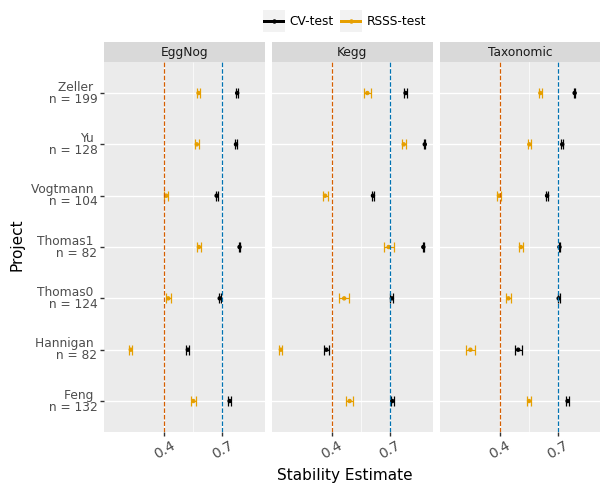

<ggplot: (2996015157909)>

In [108]:
from plotnine import scale_x_continuous, geom_vline, ggsave, theme, element_text, scale_color_discrete, ggplot, aes
import plotnine as gg


fname = "stability"
g = (
    ggplot(stab_df_plot)
    + gg.facet_wrap("~Profile")
    + gg.aes(x="Stability", y="Project", color="Analysis")
    + gg.labs(
        x="Stability Estimate",
        y="Project"    )
    + gg.geom_point(size=0.8)
    + gg.scale_x_continuous(breaks=[0.4, 0.7])
    + gg.geom_errorbarh(aes(xmin="low", xmax="up"), height=0.2)
    + gg.geom_vline(xintercept=0.4, linetype="dashed", color=COLOR_BLIND_PALETTE[-2])
    + gg.geom_vline(xintercept=0.7, linetype="dashed", color=COLOR_BLIND_PALETTE[-3])
   + gg.theme(axis_text_y=element_text(size=10, hjust=-1))
    + gg.theme_gray()
    + gg.theme(legend_position="top", legend_direction="horizontal", 
            legend_title=gg.element_blank(),
            #panel_background=gg.element_rect(fill=panel_col, color=panel_col),
            #strip_background=gg.element_rect(fill=panel_col, color=panel_col),
            #plot_background=gg.element_rect(fill="w", color="w"),
           legend_box_margin=-1,
           legend_margin=-1)
    #+ gg.guide_legend(nrow=1)
    + gg.theme(axis_text_x=element_text(size=10, rotation=30, hjust=-1))
     
    #+ gg.scale_color_brewer(type="qual", palette=2)
    + gg.scale_color_manual(COLOR_BLIND_PALETTE)
)


g.save(results_path.joinpath("combined", f"crc_{fname}_analysis.pdf"))
g.save(results_path.joinpath("combined", f"crc_{fname}_analysis.svg"))
g.save(results_path.joinpath("combined", f"crc_{fname}_analysis.png"), dpi=300)
g

/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/data/paper/combined/crc_auroc_analysis.pdf
/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/data/paper/combined/crc_auroc_analysis.svg
/mnt/lustre/scratc

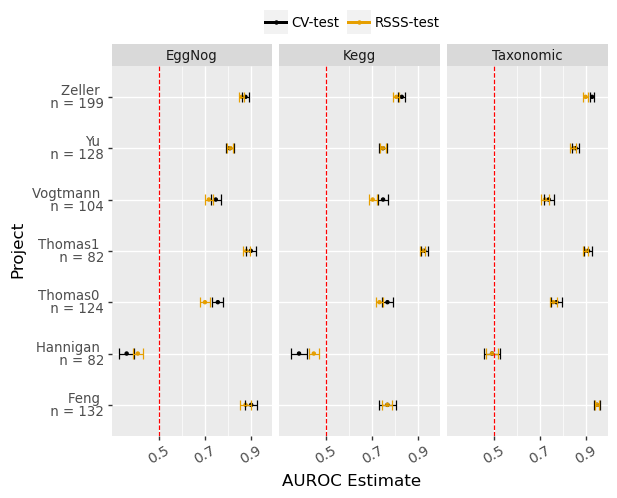

<ggplot: (2996021928569)>

In [107]:
from plotnine import scale_x_continuous, geom_vline, ggsave, theme, element_text, scale_color_discrete
import plotnine as gg

panel_col = "antiquewhite"

score_name = "AUROC"
fname = "auroc"

X = err_df.replace(project_plot_names)

g = (
    ggplot(X)
    + gg.facet_wrap("~Profile")
    + gg.aes(x=score_name, y="Project", color="Analysis")
    + gg.labs(
        x="AUROC Estimate",
        y="Project"    )
    + gg.geom_point(size=0.8)
    + gg.scale_x_continuous(breaks=[0.5, 0.7, 0.9])
    + gg.geom_errorbarh(aes(xmin="low", xmax="up"), height=0.2)
    + gg.geom_vline(xintercept=0.5, linetype="dashed", color="red")
#     + geom_vline(xintercept=0.7, linetype="dashed", color="blue")
    + gg.theme_gray(base_size=12)
    + gg.theme(legend_position="top", legend_direction="horizontal", 
            legend_title=gg.element_blank(),
            #panel_background=gg.element_rect(fill=panel_col, color=panel_col),
            #strip_background=gg.element_rect(fill=panel_col, color=panel_col),
            #plot_background=gg.element_rect(fill="w", color="w"),
           legend_box_margin=-1,
           legend_margin=-1)
    #+ gg.guide_legend(nrow=1)
    + gg.theme(axis_text_x=element_text(size=10, rotation=30, hjust=-1))
    #+ gg.scale_color_brewer(type="qual", palette=2)
    + gg.scale_color_manual(COLOR_BLIND_PALETTE)
)

g.save(results_path.joinpath("combined", f"crc_{fname}_analysis.pdf"))
g.save(results_path.joinpath("combined", f"crc_{fname}_analysis.svg"))
g.save(results_path.joinpath("combined", f"crc_{fname}_analysis.png"), dpi=300)
g

/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/data/paper/combined/crc_rank_analysis.pdf
/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/data/paper/combined/crc_rank_analysis.svg
/mnt/lustre/scratch/

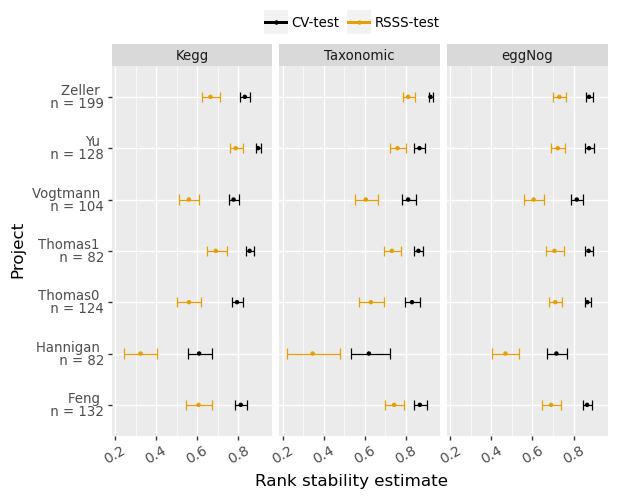

<ggplot: (2996005896989)>

In [109]:
from plotnine import scale_x_continuous, geom_vline, ggsave, theme, element_text, scale_color_discrete
import plotnine as gg

panel_col = "antiquewhite"

score_name = "mean"
fname = "rank"
xlab_str = "Rank stability estimate"


X = df.replace(project_plot_names)

g = (
    ggplot(X)
    + gg.facet_wrap("~Profile")
    + gg.aes(x=score_name, y="Project", color="Analysis")
    + gg.labs(
        x=xlab_str,
        y="Project"    
    )
    + gg.geom_point(size=0.8)
    + gg.scale_x_continuous(breaks=[0.2, 0.4, 0.6, 0.8])
    + gg.geom_errorbarh(aes(xmin="25%", xmax="75%"), height=0.2)
    #+ gg.geom_vline(xintercept=0.5, linetype="dashed", color="red")
#     + geom_vline(xintercept=0.7, linetype="dashed", color="blue")
    + gg.theme_gray(base_size=12)
    + gg.theme(legend_position="top", legend_direction="horizontal", 
            legend_title=gg.element_blank(),
            #panel_background=gg.element_rect(fill=panel_col, color=panel_col),
            #strip_background=gg.element_rect(fill=panel_col, color=panel_col),
            #plot_background=gg.element_rect(fill="w", color="w"),
           legend_box_margin=-1,
           legend_margin=-1)
    #+ gg.guide_legend(nrow=1)
    + gg.theme(axis_text_x=element_text(size=10, rotation=30, hjust=-1))
    #+ gg.scale_color_brewer(type="qual", palette=2)
    + gg.scale_color_manual(COLOR_BLIND_PALETTE)
)

g.save(results_path.joinpath("combined", f"crc_{fname}_analysis.pdf"))
g.save(results_path.joinpath("combined", f"crc_{fname}_analysis.svg"))
g.save(results_path.joinpath("combined", f"crc_{fname}_analysis.png"), dpi=300)
g

/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: rank_analysis.pdf
/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: rank_analysis.svg
/mnt/lustre/scratch/home/cloucera/projects/babelomics/metagenomic-crc/machine_learning/.venv/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/mnt/lustre/scratch/home/cloucera/projects/babelomics

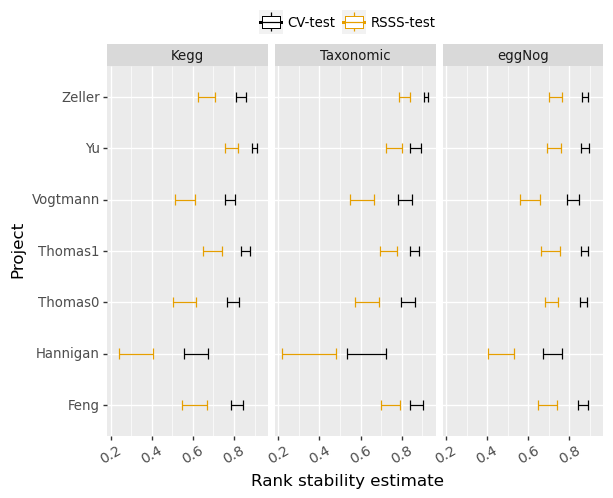

<ggplot: (2996092443133)>

In [100]:
tsv_path = results_path.joinpath("combined", "crc_rank_summary.tsv")
df = pd.read_csv(tsv_path, sep="\t")

panel_col = "antiquewhite"

score_name = "mean"
fname = "rank"
xlab_str = "Rank stability estimate"

g = (
    ggplot(df)
    + gg.facet_wrap("~Profile")
    + aes(x=score_name, y="Project", color="Analysis")
    + gg.labs(
        x=xlab_str,
        y="Project"    )
    #+ geom_point(size=0.8)
    #+ scale_x_continuous(breaks=[0.5, 0.7, 0.9])
    + gg.geom_errorbarh(aes(xmin="25%", xmax="75%"), height=0.2)
    + gg.geom_boxplot()
    #+ geom_vline(xintercept=0.5, linetype="dashed", color="red")
#     + geom_vline(xintercept=0.7, linetype="dashed", color="blue")
    + gg.theme_gray(base_size=12)
    + gg.theme(legend_position="top", legend_direction="horizontal", 
            legend_title=gg.element_blank(),
            #panel_background=gg.element_rect(fill=panel_col, color=panel_col),
            #strip_background=gg.element_rect(fill=panel_col, color=panel_col),
            #plot_background=gg.element_rect(fill="w", color="w"),
           legend_box_margin=-1,
           legend_margin=-1)
    #+ gg.guide_legend(nrow=1)
    + gg.theme(axis_text_x=element_text(size=10, rotation=30, hjust=-1))
    #+ gg.scale_color_brewer(type="qual", palette=2)
    + gg.scale_color_manual(COLOR_BLIND_PALETTE)
)

# g.save(f"{fname}_analysis.pdf")
# g.save(f"{fname}_analysis.svg")
# g.save(f"{fname}_analysis.png", dpi=300)
g

In [ ]:
def compute_support_ebm(model, quantile=None):
    # TODO: check if trained
    ebm = model["estimator"]
    ebm_global = ebm.explain_global()
    data = ebm_global.data()

    if "selector" in model.named_steps.keys():
        support = model["selector"].get_support()
    else:
        support = np.repeat(True, len(data["scores"]))

    coefs = np.zeros(support.size)
    coefs[support] = np.array(data["scores"])

    support = support * 1

    return support, coefs

In [ ]:
from scipy.stats import linregress, rankdata

def fdr(p_vals):
    ranked_p_values = rankdata(p_vals)
    p_vals_new = p_vals * len(p_vals) / ranked_p_values
    p_vals_new[p_vals_new > 1] = 1

    return p_vals_new

def compute_explanations(pipe, X, name, folder_path, profile_name, conditon="crc"):
    from sklearn.pipeline import Pipeline
    X_trans = Pipeline(pipe.steps[:-1]).transform(features)    
    X_filt = pd.DataFrame(X_trans, index=X.index, columns=X.columns[pipe["selector"].get_support()])
    
    model = pipe["estimator"]
    ebm_local = model.explain_local(X_filt)

    explanations = [ebm_local.data(irow) for irow in range(X_filt.shape[0])]
    explanation_df = pd.concat(
        [pd.Series(x["scores"], index=X_filt.columns, name="score") for x in explanations],
        axis=1,
    )
    explanation_df.columns = X_filt.index
    explanation_df = explanation_df.T

    explanations_reg = [
        linregress(X[col], explanation_df[col]) for col in X_filt.columns
    ]
    explanations_coef = pd.Series(
        [reg[0] for reg in explanations_reg], index=X_filt.columns, name="r_coeff"
    )
    explanations_sig = pd.Series(
        [coef > 0 for coef in explanations_coef], index=X_filt.columns, name="r_sign"
    )
    explanations_pval = pd.Series(
        [reg[3] for reg in explanations_reg], index=X_filt.columns, name="r_pvalue"
    )
    explanations_pval_fdr = pd.Series(
        fdr(explanations_pval), index=X_filt.columns, name="r_pvalue_fdr"
    )

    explanations_rank = explanation_df.abs().mean()
    explanations_rank.name = "score"
    explanations_analysis = pd.concat(
        (explanations_rank, explanations_coef, explanations_sig, explanations_pval, explanations_pval_fdr),
        axis=1,
    )
    
    explanations_analysis = explanations_analysis.sort_values(by="score", ascending=False)

    dataset_fpath = folder_path.joinpath(
        f"{condition}_{profile_name}_{name}_explanations.tsv"
    )
    explanations_analysis.to_csv(dataset_fpath, sep="\t", index_label="feature_id")
    
    return explanations_analysis

In [ ]:
profile = "KEGG_KOs"
project = "Thomas1"
pipe = results_cp_dict[profile][project]["cv"]["estimator"][0]

In [ ]:
x = pipe["estimator"]

In [ ]:
pipe["selector"].get_support().sum()

In [ ]:
from mlgut import datasets

features, metadata = datasets.build_condition_dataset(
    condition="CRC", profile_name=profile, ext="jbl"
)
features = datasets.filter_egg(features)

In [ ]:
i=0
explanations_analysis = compute_explanations(pipe, features, name=f"all{i:2d}", folder_path=pathlib.Path("."), profile_name="profile", conditon="crc")

In [ ]:
kegg_explanations = {}
for project in PROJECT_NAMES_DICT.values():
    explanations = [pd.Series(compute_support_ebm(pipe)[1], index=features.columns) for pipe in results_cp_dict[profile][project]["cv"]["estimator"]]
    explanations = pd.concat(explanations, axis=1)
    kegg_explanations[project] = explanations

In [ ]:
features.shape

In [ ]:
import joblib
joblib.dump(kegg_explanations, "kegg_cv_explanations.jbl")
joblib.dump(taxo_explanations, "taxo_cv_explanations.jbl")
joblib.dump(ogs_explanations, "ogs_cv_explanations.jbl")

In [ ]:
for i, explanation_dict in enumerate([kegg_explanations, taxo_explanations, ogs_explanations]):
    profile = ["kegg", "taxo", "ogs"][i]
    for project in explanation_dict.keys():
        explanation_dict[project].to_csv(f"{profile}_{project}_explanations_cv.tsv", sep="\t")

In [ ]:
taxo_explanations = {}
profile="centrifuge"
features, metadata = datasets.build_condition_dataset(
    condition="CRC", profile_name=profile, ext="jbl"
)
features = datasets.filter_egg(features)
tax_id = "9606"
print(tax_id in features.columns)
features = features.drop(tax_id, axis=1)
for project in PROJECT_NAMES_DICT.values():
    explanations = [pd.Series(compute_support_ebm(pipe)[1], index=features.columns) for pipe in results_cp_dict[profile][project]["cv"]["estimator"]]
    explanations = pd.concat(explanations, axis=1)
    taxo_explanations[project] = explanations

In [ ]:
ogs_explanations = {}
profile="OGs"
features, metadata = datasets.build_condition_dataset(
    condition="CRC", profile_name=profile, ext="jbl"
)
features = datasets.filter_egg(features)
for project in PROJECT_NAMES_DICT.values():
    explanations = [pd.Series(compute_support_ebm(pipe)[1], index=features.columns) for pipe in results_cp_dict[profile][project]["cv"]["estimator"]]
    explanations = pd.concat(explanations, axis=1)
    ogs_explanations[project] = explanations

In [ ]:
explanations = ogs_explanations
rank_stabs = {}
df = pd.DataFrame(columns=["stability", "lower", "upper", "Project", "q"])
for project in PROJECT_NAMES_DICT.values():
    x = explanations[project]
    rank_stabs[project] = [stab.confidenceIntervals((x.apply(lambda y: y > np.quantile(y, q)) * 1).T.values) for q in np.arange(0.01, 1, 0.01)]
    d = pd.DataFrame(rank_stabs[project])
    d["Project"] = project
    d["q"] = np.arange(0.01, 1, 0.01)
    df = pd.concat((df, d), axis=0)

In [ ]:
sns.set_context("notebook")
plt.figure(figsize=(16/1.2, 9/1.2))
g = sns.lineplot(data=df.loc[df.q>0.65, :], x="q", y="stability", hue="Project", palette="colorblind")
plt.xlabel("Selection Quantile")
plt.ylabel(f"{profile} Rank Stability Estimate")
plt.axhline(0.4, color="red", linestyle="--")
plt.axhline(0.7, color="black", linestyle="--")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.08), ncol=8)
# plt.legend(ncol=len(PROJECT_NAMES_DICT.values()), bbox_to_anchor=(0.05, 1))

In [ ]:
features.shape

In [ ]:
taxo_explanations_stab = {}
profile="centrifuge"
features, metadata = datasets.build_condition_dataset(
    condition="CRC", profile_name=profile, ext="jbl"
)
features = datasets.filter_egg(features)
tax_id = "9606"
print(tax_id in features.columns)
features = features.drop(tax_id, axis=1)
for project in PROJECT_NAMES_DICT.values():
    explanations = [pd.Series(compute_support_ebm(pipe)[1], index=features.columns) for pipe in results_cp_dict[profile][project]["cv"]["estimator"]]
    explanations = pd.concat(explanations, axis=1)
    explanations.to_csv(f"{profile}_{project}_explanations_stab.tsv", sep="\t")
    taxo_explanations_stab[project] = explanations

In [ ]:
from scipy.stats import weightedtau
explanations[project]

In [ ]:
PROJECT_ORDER

In [ ]:
explanations = kegg_explanations
wtau_df = pd.DataFrame(columns=PROJECT_ORDER)
for project in PROJECT_ORDER:
    wtau = []
    for i in range(explanations[project].shape[1]):
        for j in range(i+1, explanations[project].shape[1]):
            wtau.append(weightedtau(explanations[project].iloc[:, i], explanations[project].iloc[:, j])[0])
    wtau_df[project] = wtau

In [ ]:
kegg_wtau = wtau_df
kegg_wtau["Profile"] = "Kegg"
kegg_wtau.plot(kind="box", figsize=(16/2, 9/2))

In [ ]:
explanations = ogs_explanations
wtau_df = pd.DataFrame(columns=PROJECT_ORDER)
for project in ["Zeller"]:
    wtau = []
    for i in range(explanations[project].shape[1]):
        for j in range(i+1, explanations[project].shape[1]):
            wtau.append(weightedtau(explanations[project].iloc[:, i], explanations[project].iloc[:, j])[0])
    wtau_df[project] = wtau

In [ ]:
egg_wtau = wtau_df
egg_wtau["Profile"] = "eNog"
egg_wtau.plot(kind="box", figsize=(16/2, 9/2))

In [ ]:
for pr

In [ ]:
explanations = taxo_explanations
wtau_df = pd.DataFrame(columns=PROJECT_ORDER)
for project in PROJECT_ORDER:
    wtau = []
    for i in range(explanations[project].shape[1]):
        for j in range(i+1, explanations[project].shape[1]):
            wtau.append(weightedtau(explanations[project].iloc[:, i], explanations[project].iloc[:, j])[0])
    wtau_df[project] = wtau

In [ ]:
taxo_wtau = wtau_df
taxo_wtau["Profile"] = "Taxo"
taxo_wtau.plot(kind="box", figsize=(16/2, 9/2))

In [ ]:
wtau_df = pd.concat((kegg_wtau, egg_wtau, taxo_wtau), axis=0)
wtau_df = wtau_df.melt(id_vars=["Profile"], var_name="Project", value_name="Score")

In [ ]:
wtau_df = wtau_df.replace({"Kegg": "Kegg", "Taxo": "Taxonomic", "eNog": "eggNog"})

In [ ]:
fac = 2
plt.figure(figsize=(16/fac, 9/fac))
sns.boxplot(data=wtau_df, x="Project", y="Score", hue="Profile", palette="colorblind")

In [ ]:
explanations = taxo_explanations
wtau_df = pd.DataFrame(columns=PROJECT_ORDER)
for project_x in PROJECT_ORDER:
    for i in range(explanations[project].shape[1])
    for project_y in PROJECT_ORDER:
        wtau = []
        for i in range(explanations[project].shape[1]):

            
        for j in range(i+1, explanations[project].shape[1]):
            wtau.append(weightedtau(explanations[project].iloc[:, i], explanations[project].iloc[:, j])[0])
    wtau_df[project] = wtau

In [ ]:
from sklearn.metrics import pairwise_distances


In [ ]:
distance = lambda x, y: weightedtau(x, y)[0]

In [ ]:
PROJECT_ORDER

In [ ]:
project_x = PROJECT_ORDER[2]
project_y = PROJECT_ORDER[3]

In [ ]:
kegg_pairwise = {}

In [ ]:
kegg_pairwise[(project_x, project_y)] = pairwise_distances(
    kegg_explanations[project_x].T.iloc[:100, :], 
    kegg_explanations[project_y].T.iloc[:100, :],
    metric=distance,
    n_jobs=-1)

In [ ]:
pd.Series(kegg_pairwise[(project_x, project_y)].ravel(), name=f"({project_x}, {project_y})").plot(kind="box")

In [ ]:
condition = "CRC"
profile = "centrifuge"

In [ ]:
rpath = results_folder.joinpath(condition.lower(), f"{condition.lower()}_{profile.lower()}_results")
fpath = rpath.joinpath(f"{condition}_{profile}_lopo_with _oracle_support.tsv")
features_used = pd.read_csv(fpath, sep="\t", index_col=0).index.astype(str)
features_used

In [ ]:
features_used.shape

In [ ]:
features.shape

In [ ]:
metadata.shape

In [ ]:
y = metadata.DISEASE.str.lower() == "crc"

In [ ]:
projects = metadata.PROJECT.copy()
projects = projects.replace(PROJECT_NAMES_DICT)

In [ ]:
from sklearn.model_selection import LeaveOneGroupOut, cross_validate

In [ ]:
from sklearn.feature_selection import SelectKBest
from mlgut.models import get_taxonomic_model

In [ ]:
import numpy as np
import pandas as pd
from interpret.glassbox import ExplainableBoostingClassifier
from scipy.spatial.distance import pdist
from sklearn import metrics
from sklearn.feature_selection import SelectFdr, SelectFpr, SelectPercentile
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, KBinsDiscretizer

In [ ]:
projects_unique = np.unique_(projects)
for i, res in enumerate(cvres):
    project_out = projects_unique[i]
    pd.concat([pd.Series(compute_support_ebm(m), index=features_used) for m in res['estimator']])        

In [ ]:
"hola"


In [ ]:
taxo_explanations_stab = {}
profile="centrifuge"
features, metadata = datasets.build_condition_dataset(
    condition="CRC", profile_name=profile, ext="jbl"
)
tax_id = "9606"
print(tax_id in features.columns)
features = features.drop(tax_id, axis=1)
for project in PROJECT_NAMES_DICT.values():
    print(f"start {project}")
    explanations = [pd.Series(compute_support_ebm(pipe)[1], index=features.columns) for pipe in results_stab_dict[profile][project]["estimator"]]
    explanations = pd.concat(explanations, axis=1)
    taxo_explanations_stab[project] = explanations
    print(f"finished {project}")
joblib.dump(taxo_explanations_stab, "taxo_stab_explanation.jbl")

In [ ]:
kegg_explanations_stab = {}
profile="KEGG_KOs"
features, metadata = datasets.build_condition_dataset(
    condition="CRC", profile_name=profile, ext="jbl"
)
features = datasets.filter_egg(features)
for project in PROJECT_NAMES_DICT.values():
    print(f"start {project}")
    explanations = [pd.Series(compute_support_ebm(pipe)[1], index=features.columns) for pipe in results_stab_dict[profile][project]["estimator"]]
    explanations = pd.concat(explanations, axis=1)
    kegg_explanations_stab[project] = explanations
    print(f"finished {project}")
joblib.dump(kegg_explanations_stab, "kegg_stab_explanation.jbl")

In [ ]:
ogs_explanations_stab = {}
profile="OGs"
features, metadata = datasets.build_condition_dataset(
    condition="CRC", profile_name=profile, ext="jbl"
)
features = datasets.filter_egg(features)
for project in PROJECT_NAMES_DICT.values():
    print(f"start {project}")
    explanations = [pd.Series(compute_support_ebm(pipe)[1], index=features.columns) for pipe in results_stab_dict[profile][project]["estimator"]]
    explanations = pd.concat(explanations, axis=1)
    ogs_explanations_stab[project] = explanations
    print(f"finished {project}")
joblib.dump(ogs_explanations_stab, "ogs_stab_explanation.jbl")

In [ ]:
profiles = ["Taxonomic", "eggNog", "Kegg"]

df = pd.DataFrame(columns=PROJECT_ORDER + ["Profile"])

for profile in profiles:
    print(f"start profile {profile}")
    if profile == "Taxonomic":
        explanations = taxo_explanations_stab
    elif profile == "Kegg":
        explanations = kegg_explanations_stab
    elif profile == "eggNog":
        explanations = ogs_explanations_stab
    df_i = pd.DataFrame(columns=PROJECT_ORDER)
    for project in PROJECT_ORDER:
        print(f"start project {project}")
        wtau = []
        for i in range(explanations[project].shape[1]):
            for j in range(i+1, explanations[project].shape[1]):
                wtau.append(weightedtau(explanations[project].iloc[:, i], explanations[project].iloc[:, j])[0])
        df_i[project] = wtau
        print(f"end project {project}")
    df_i["Profile"] = profile
    df = pd.concat((df, df_i), axis=0)
    print(f"end profile {profile}")
    print("")
df["Analysis"] = "RSSS-test"
stab_rank = df.copy()

In [ ]:
cv_rank = pd.concat((kegg_wtau, egg_wtau, taxo_wtau), axis=0).copy().replace({"Kegg": "Kegg", "Taxo": "Taxonomic", "eNog": "eggNog"})
cv_rank["Analysis"] = "CV-test"

In [ ]:
rank_df = pd.concat((cv_rank, stab_rank), axis=0)
rank_df.to_csv("rank.tsv", sep="\t", index=False)

In [ ]:
df = rank_df.melt(id_vars=["Profile", "Analysis"], var_name="Project", value_name="Score")

In [ ]:
panel_col = "antiquewhite"

score_name = "mean"
fname = "rank"
xlab_str = "Rank stability estimate"

X = df.groupby(["Profile", "Analysis", "Project"])["Score"].describe()[["mean", "25%", "75%"]].reset_index()

g = (
    ggplot(X)
    + gg.facet_wrap("~Profile")
    + aes(x=score_name, y="Project", color="Analysis")
    + labs(
        x=xlab_str,
        y="Project"    )
    #+ geom_point(size=0.8)
    #+ scale_x_continuous(breaks=[0.5, 0.7, 0.9])
    + geom_errorbarh(aes(xmin="25%", xmax="75%"), height=0.2)
    + gg.geom_boxplot()
    #+ geom_vline(xintercept=0.5, linetype="dashed", color="red")
#     + geom_vline(xintercept=0.7, linetype="dashed", color="blue")
    + gg.theme_gray(base_size=12)
    + theme(legend_position="top", legend_direction="horizontal", 
            legend_title=gg.element_blank(),
            #panel_background=gg.element_rect(fill=panel_col, color=panel_col),
            #strip_background=gg.element_rect(fill=panel_col, color=panel_col),
            #plot_background=gg.element_rect(fill="w", color="w"),
           legend_box_margin=-1,
           legend_margin=-1)
    #+ gg.guide_legend(nrow=1)
    + theme(axis_text_x=element_text(size=10, rotation=30, hjust=-1))
    #+ gg.scale_color_brewer(type="qual", palette=2)
    + gg.scale_color_manual(COLOR_BLIND_PALETTE)
)

g.save(f"{fname}_analysis.pdf")
g.save(f"{fname}_analysis.svg")
g.save(f"{fname}_analysis.png", dpi=300)
g

In [ ]:
err_df.to_csv("error_summary.tsv", sep="\t", index=False)

In [ ]:
stab_df.to_csv("stability_summary.tsv", sep="\t", index=False)

In [ ]:
X.to_csv("rank_summary.tsv", sep="\t", index=False)